# 2/19/20
***
Мне снова задали вопрос о коррелированном отборе, поэтому надо с ним разобраться

In [165]:
import numpy as np
import uproot
import uproot_methods
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplhep as hep
from glob import glob

# %matplotlib inline

# sns.set(rc={'figure.figsize':(13,7)}, font_scale=1.7)
# plt.style.use('seaborn-whitegrid')

import matplotlib

def my_style(title='', xtitle='', ytitle='', gridstyle=':'):
    plt.grid(linestyle=gridstyle)
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    

%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='paper', ticks=True, grid=True, gridlines='--', figsize=(13, 9), fscale=2)
# jtplot.style(theme='monokai', context='talk', ticks=True, grid=True, gridlines='--', figsize=(13, 9), fscale=2)
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']

In [3]:
import warnings
warnings.filterwarnings("ignore")

Посмотрю картинки, на которых видно коррелированный отбор

In [3]:
ebeam = 900
mom_tree_exp = uproot.open(glob(f'../../outputs/19/trees/{ebeam}*.root')[0])['pic_mom']
mom_tree_mc = uproot.open(glob(f'../../outputs/model_old_v7/trees/{ebeam}*.root')[0])['pic_mom']

In [4]:
mom_df_exp = mom_tree_exp.pandas.df()
mom_df_mc = mom_tree_mc.pandas.df(flatten=False).query('align>0.8')

In [5]:
p_cut = 2 * (0.0869 * ebeam - 36.53)
p0 = np.sqrt(ebeam**2 - 497.6**2)

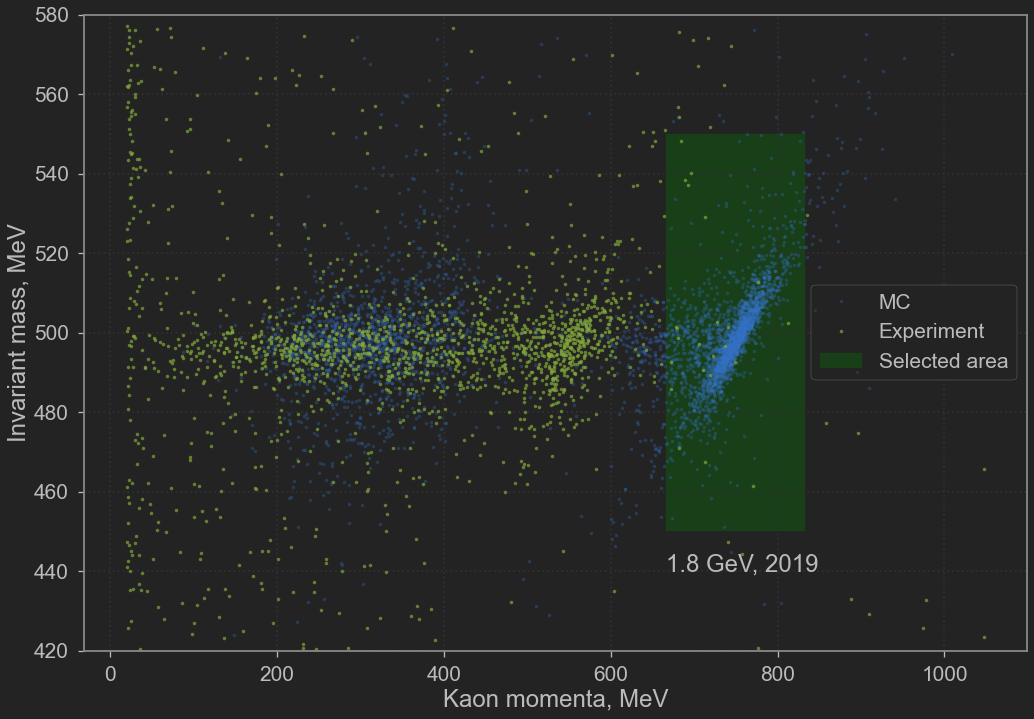

In [6]:
plt.plot(mom_df_mc.momentum, mom_df_mc.mass, '.', label='MC', ms=7, alpha=0.3)#, c='orange')
plt.plot(mom_df_exp.momentum, mom_df_exp.mass, '.', label='Experiment', ms=7, alpha=0.7)#, c='red', alpha=0.7)
plt.fill_between([p0-p_cut, p0+p_cut], [450, 450], [550, 550], color='green', alpha=0.3, label='Selected area')
plt.grid(linestyle=":")
# plt.xlim(50, 350);
plt.ylim(420, 580);
plt.text(p0-p_cut, 440, f"{ebeam*2e-3:.1f} GeV, 2019", size=24);
my_style('','Kaon momenta, MeV','Invariant mass, MeV')
plt.legend(frameon=True);
# plt.savefig(f'outputs/images/7_invMass_mom_dist_19_{ebeam*2e-3:.1f}GeV.png')

Проверяю гипотезу о том, что фон пикуется, для этого
1. Смотрю распределение по импульсу каона, беру сайд-бенды
2. Смотрю как события из сайд-бендов ведут себя на картинке и инвариантной массой

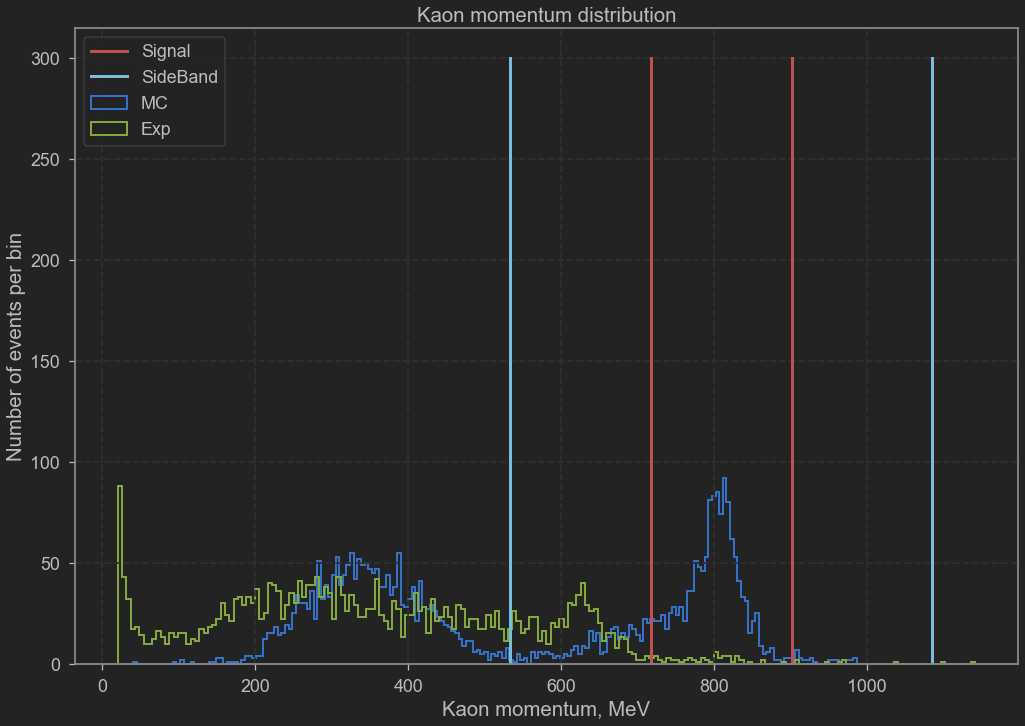

In [54]:
sideband = 3*p_cut
plt.hist(mom_df_mc.momentum, bins=200, histtype='step', lw=2, label='MC');
plt.hist(mom_df_exp.momentum, bins=200, histtype='step', lw=2, label='Exp');
plt.plot([p0-p_cut, p0-p_cut], [0, 300], c='r', lw=3)
plt.plot([p0+p_cut, p0+p_cut], [0, 300], c='r', lw=3, label='Signal')
plt.plot([p0-sideband, p0-sideband], [0, 300], c='c', lw=3)
plt.plot([p0+sideband, p0+sideband], [0, 300], c='c', lw=3, label='SideBand');
plt.legend(frameon=True)
plt.title('Kaon momentum distribution')#'Распределение по импульсу каона\n(проекция предыдущей картинки)')
plt.ylabel('Number of events per bin');
plt.xlabel('Kaon momentum, MeV');
# plt.xlim(100, 500)

In [55]:
sideband_area = dict()
sideband_area['exp'] = mom_df_exp.query('abs(momentum-@p0)<@sideband&abs(momentum-@p0)>@p_cut')
sideband_area['mc'] = mom_df_mc.query('abs(momentum-@p0)<@sideband&abs(momentum-@p0)>@p_cut')

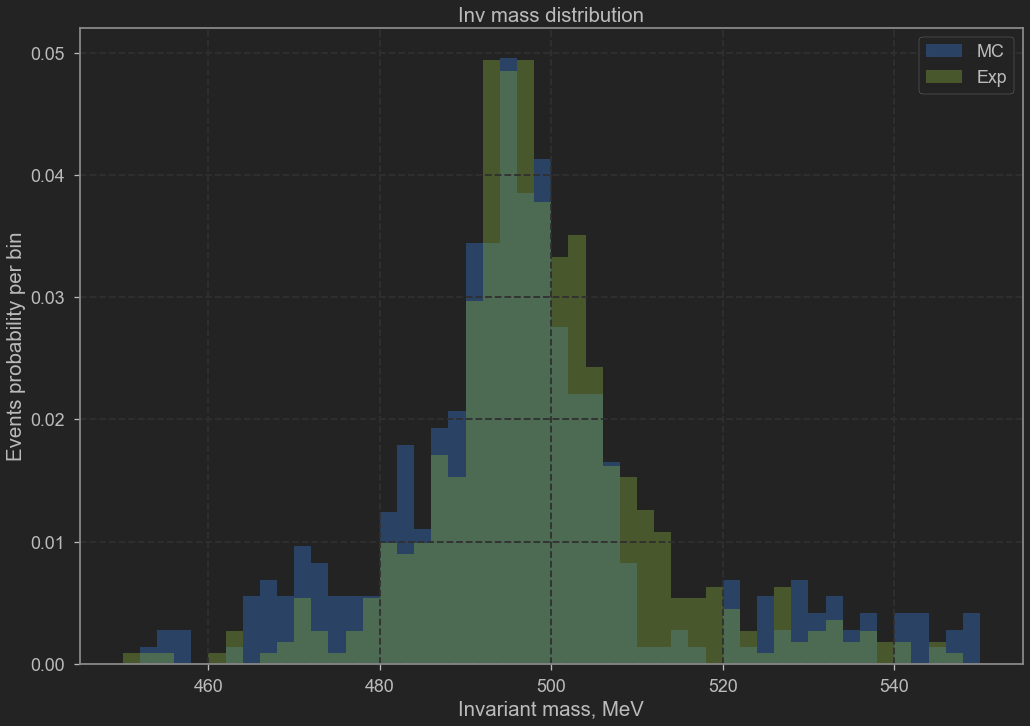

In [56]:
plt.hist( sideband_area['mc'].mass, 
         bins=50, histtype='stepfilled', lw=2, density=True, range=(450, 550), alpha=0.4, label='MC' );
plt.hist( sideband_area['exp'].mass, 
         bins=50, histtype='stepfilled', lw=2, density=True, range=(450, 550), alpha=0.4, label='Exp' );
plt.legend(frameon=True);
plt.title('Inv mass distribution')#Распределение по инвариантной массе\nдля side-band области в импульсном распределении')
plt.xlabel('Invariant mass, MeV');
plt.ylabel('Events probability per bin');

Видно, что в области массы $K_S$ наблюдается пик, однако этот пик также присутствует в моделировании, что говорит о том, что там находятся неотобранные мной $K_S$-мезоны, поэтому это вообще не side-bands и так делать нельзя

*Ради интереса попробую повернуть оси*

In [57]:
cov_matrix = mom_df_mc.query('abs(momentum-@p0)<@p_cut')[['momentum','mass']].cov().values
cov_matrix

array([[1214.94016536,  214.4852194 ],
       [ 214.4852194 ,  149.12110909]])

In [58]:
vP = ( cov_matrix[0,0] )
vM = ( cov_matrix[1,1] )
covMP = cov_matrix[0,1]

phi = (1/2)*np.arcsin( covMP/(vP - vM) )

Угол поворота найден, теперь нужно повернуть координаты

In [59]:
A = np.array([[0.5, 0], [0, 1]])
R = np.array([ [np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)] ] )

In [60]:
A = mom_df_mc[['momentum', 'mass']].values.T
B = mom_df_exp[['momentum', 'mass']].values.T

In [61]:
new_df_mc = pd.DataFrame( np.matmul(R, A).T )
new_df_exp = pd.DataFrame( np.matmul(R, B).T )

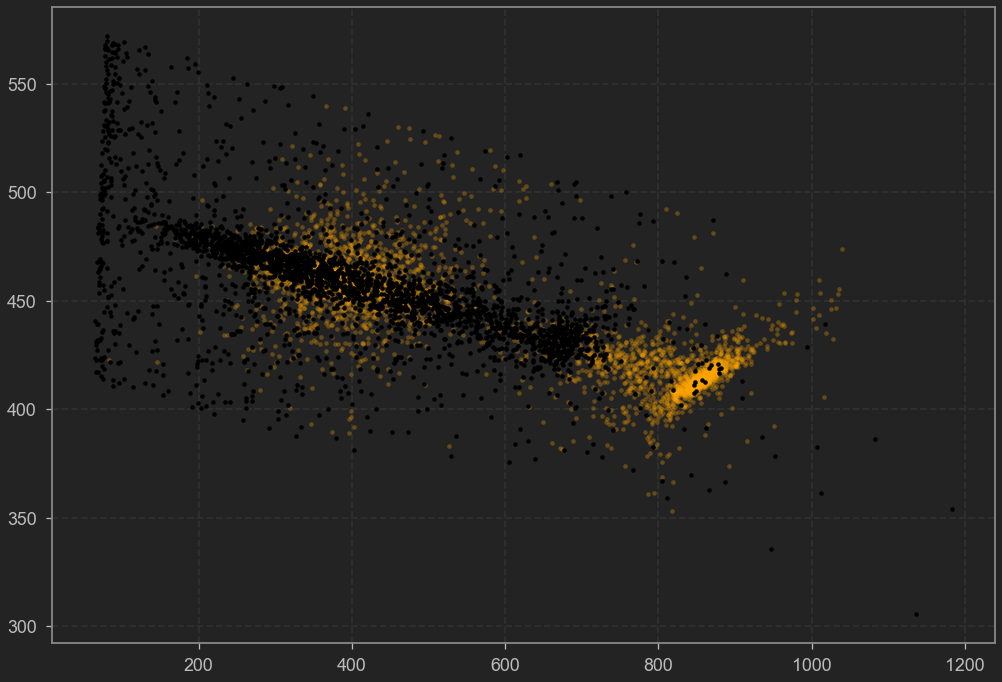

In [64]:
plt.plot(new_df_mc[0], new_df_mc[1], '.', label='MC', alpha=0.3, c='orange')
plt.plot(new_df_exp[0], new_df_exp[1], '.', label='Exp', c='black')

## Аппроксимация одним Гауссом

In [65]:
def fcn_tester():
    a = []
    for _ in range(500):
        data = pf.gen_toy(pf.gaussian, 5000, bound=bound, mean=497.617, sigma=5, quiet=True);
        unbinned_likelihood = pf.UnbinnedLH(pf.gaussian, data);
        minuit = iminuit.Minuit(unbinned_likelihood, mean=497.6, sigma=5);
        minuit.migrad();
        a.append( minuit.fval )
    return a

In [66]:
data = np.random.normal(497.6, 9, 7000)

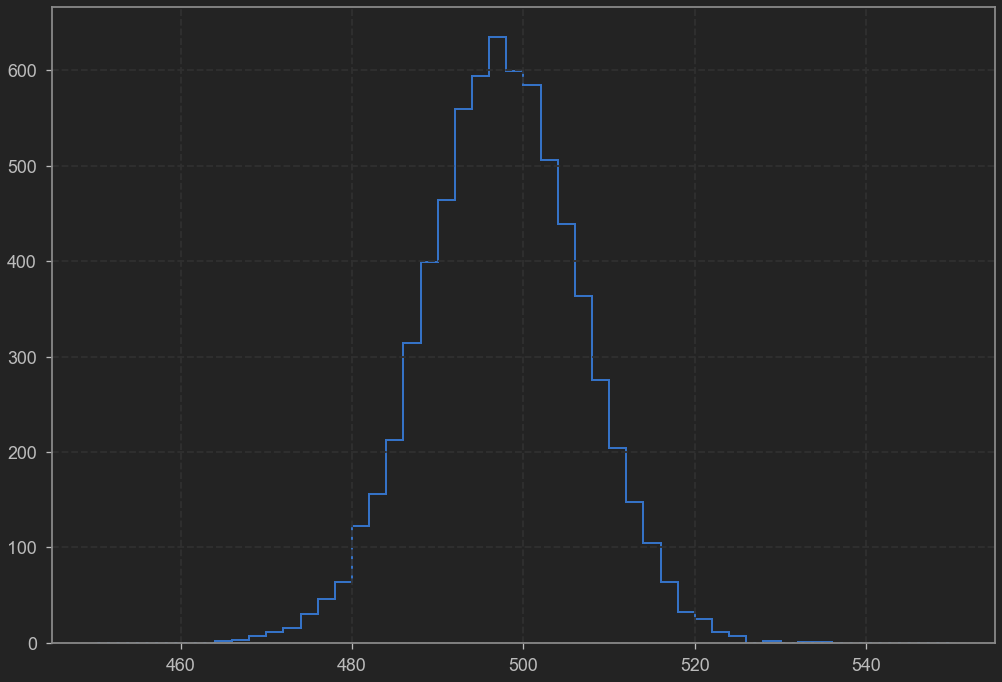

In [67]:
plt.hist(data, bins=50, range=(450, 550), histtype='step', lw=2);

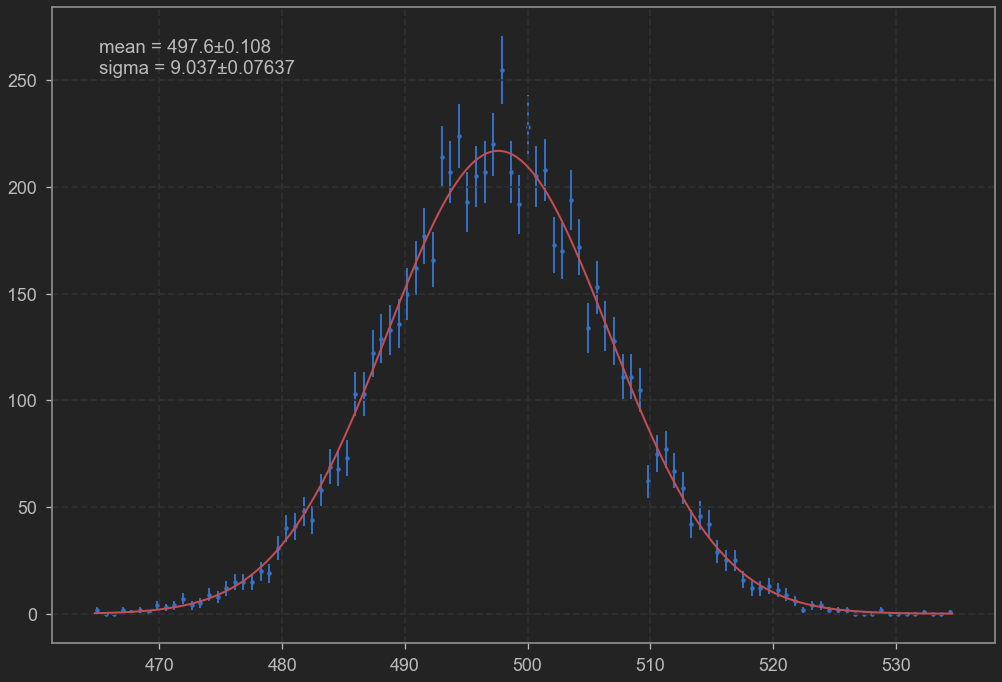

In [68]:
import probfit as pf
import iminuit
unbinned_likelihood = pf.UnbinnedLH(pf.gaussian, data)
minuit = iminuit.Minuit(unbinned_likelihood, mean=497.6, sigma=5);
minuit.migrad();
unbinned_likelihood.draw(minuit);

In [69]:
# np.random.seed(0)
bound = (497.6-40, 497.6+40);
data = pf.gen_toy(pf.gaussian, 5000, bound=bound, mean=497.617, sigma=5, quiet=True);
# plt.grid(linestyle=':');

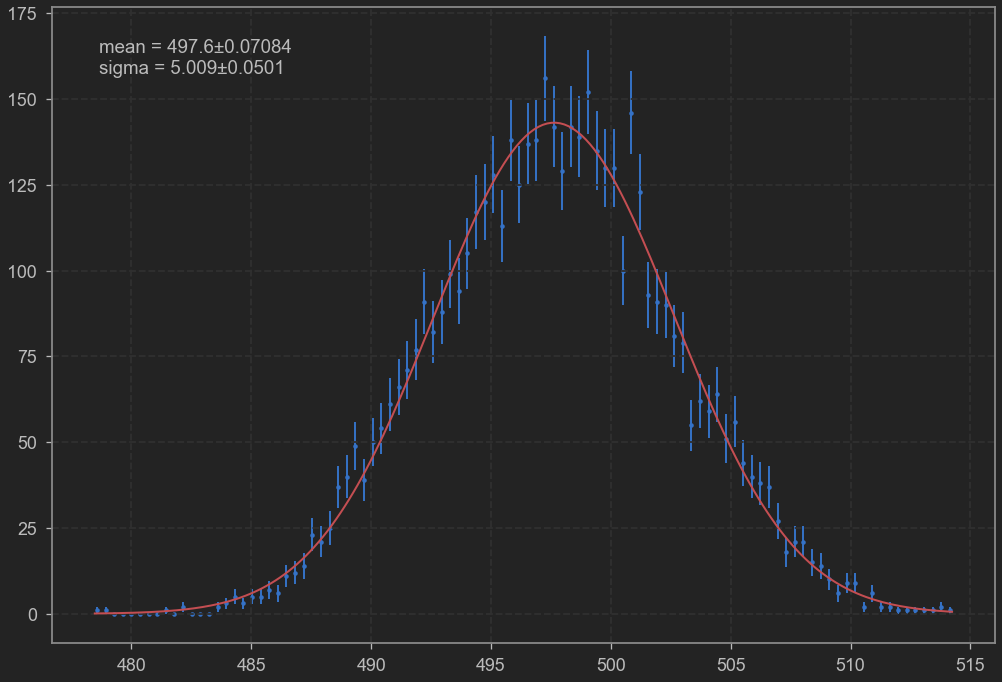

In [70]:
unbinned_likelihood = pf.UnbinnedLH(pf.gaussian, data);
minuit = iminuit.Minuit(unbinned_likelihood, mean=497.6, sigma=5);
minuit.migrad();
unbinned_likelihood.draw(minuit);

In [71]:
minuit.fval

15151.283489027144

In [72]:
a = []
for _ in range(500):
    data = pf.gen_toy(pf.gaussian, 5000, bound=bound, mean=497.617, sigma=5, quiet=True);
    unbinned_likelihood = pf.UnbinnedLH(pf.gaussian, data);
    minuit = iminuit.Minuit(unbinned_likelihood, mean=497.6, sigma=5);
    minuit.migrad();
    a.append( minuit.fval );

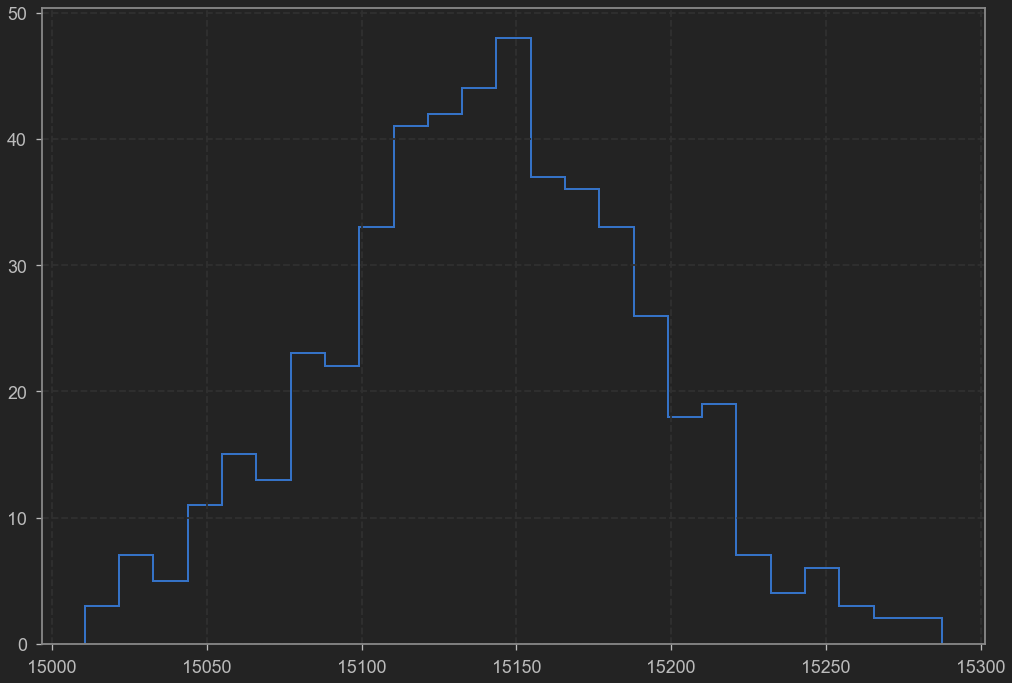

In [74]:
plt.hist(a, bins=25, histtype='step', lw=2);

Добавлю это в файл `Analysis.ipynb`

## Фит. функция  - вторая часть
____
Найду истинные пионы из распада $K_S$ в MC, привяжу их к реконструированным и отстрою инвариантную массу.

In [9]:
def select_charge_df(mc_gen, mc_rec, charge=1):
    mc_gen_plus = mc_gen.query('(simorig==310)&(simtype==211*@charge)').copy().drop(['simorig','simtype'], axis=1).\
               reset_index(level=1, drop=True)
    mc_rec_plus = mc_rec.query('tcharge==@charge')
    mc_plus = mc_rec_plus.merge(mc_gen_plus, on='entry').drop(['tcharge'],axis=1).dropna().\
                            rename({'vec_x':'rec', 'vec_y':'gen'},axis=1)
    mc_plus['diff'] = [ x.angle(y) for x,y in zip(mc_plus.rec.values, mc_plus.gen.values)]
    mc_plus = mc_plus.reset_index()
    mc_plus = mc_plus.loc[ mc_plus.groupby('entry')['diff'].idxmin() ].copy().set_index('entry')
    return mc_plus.query('diff<0.1')

def find_pions_from_ks_decay(mc):
    mc_gen = mc.pandas.df( branches=['emeas', 'simtype', 'simorig', 'simtheta', 'simphi', 'simmom'] )
    mc_gen = vector_creator(mc_gen, 'simmom', 'simtheta', 'simphi').drop(['simmom', 'simtheta', 'simphi'], axis=1)
    
    mc_rec = mc.pandas.df( branches=['nt', 'tth', 'tphi', 'tcharge', 'tptot'] ).query('nt>1').drop(['nt'], axis=1)
    mc_rec = vector_creator(mc_rec, 'tptot', 'tth', 'tphi').drop(['tptot', 'tth', 'tphi'], axis=1)
       
    return select_charge_df(mc_gen, mc_rec, 1), select_charge_df(mc_gen, mc_rec, -1)

def vector_creator(df, p='tptot', th='tth', ph='tphi'):
    df['vec'] = uproot_methods.TVector3Array.from_spherical(df[p], df[th], df[ph])
    return df

def get_df_charged(ks_table, charge=1):
    df_plus = pd.DataFrame( np.where(ks_table['charge[0]']==charge, 
        [ ks_table['kspipt[0]'], ks_table['kspith[0]'], ks_table['kspiphi[0]'] ], 
        [ ks_table['kspipt[1]'], ks_table['kspith[1]'], ks_table['kspiphi[1]'] ] ).T, index=ks_table.index, 
                  columns=['p', 'th', 'phi'] )
    return df_plus

def drop_hard(ks_table): #remove events with hard photons outside selection band 
    x = ks_table['emeas']*2e-3
    th = 0.205/(x-0.732) + 0.14
    mKs = 497.6
    p0 = np.sqrt( ks_table['emeas']**2 - mKs**2  )
    MOMENTUM, MASS = ks_table['ksptot'], ks_table['ksminv']
    c1 = ( np.abs( (MASS - mKs)*np.cos(th) - (MOMENTUM - p0)*np.sin(th) ) < 10 )
    c2 = ( np.abs( (MASS - mKs)*np.sin(th) + (MOMENTUM - p0)*np.cos(th) ) < 200 )
    return ks_table.loc[c1&c2]

def find_pions_from_ks_decay_corrected(mc):
    mc_gen = mc.pandas.df( branches=['emeas', 'simtype', 'simorig', 'simtheta', 'simphi', 'simmom'] )
    mc_gen = vector_creator(mc_gen, 'simmom', 'simtheta', 'simphi').drop(['simmom', 'simtheta', 'simphi'], axis=1)
    
    ks_table = mc.pandas.df(branches=['kspiphi', 'kspith', 'kspipt', 'kstype', 'ksvind', 'ksptot', 'ksminv', 'emeas'])
    ks_table = drop_hard(ks_table)
    charge = mc.array(branch=['tcharge'])
    for r in ks_table.iterrows():
        ks_table.at[r[0], 'charge[0]'] = charge[ r[0][0], int(r[1]['ksvind[0]']) ]
        ks_table.at[r[0], 'charge[1]'] = charge[ r[0][0], int(r[1]['ksvind[1]']) ]
    df_plus = get_df_charged(ks_table, 1)
    df_minus = get_df_charged(ks_table, -1)
    
    df_plus = vector_creator(df_plus, 'p', 'th', 'phi').drop(['p','th','phi'], axis=1).reset_index(level=1)
    df_plus['tcharge'] = 1
    
    df_minus = vector_creator(df_minus, 'p', 'th', 'phi').drop(['p','th','phi'], axis=1).reset_index(level=1)
    df_minus['tcharge'] = -1        

    return select_charge_df(mc_gen, df_plus, 1), select_charge_df(mc_gen, df_minus, -1)

def build_decay(mc_plus, mc_minus, merge_field='rec'):
    mP = mc_plus[[merge_field]].rename({merge_field : 'plus'},axis=1)
    mM = mc_minus[[merge_field]].rename({merge_field : 'minus'},axis=1)
    
    merged_table = mP.merge(mM, on='entry')
    merged_table['angle'] = [ x.angle(y) for x,y in zip(merged_table['plus'].values, \
                                                        merged_table['minus'].values)]
    return merged_table
def vector3_to_vector4( series, mass ):
    coords = np.array(list( map( lambda x: np.array( [x.x, x.y, x.z] ) , series ) ) )
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
    return uproot_methods.TLorentzVectorArray.from_xyzm(x, y, z, mass)
def get_mass_table(df):
    mPi = 139.6
    df = df.copy()
    df['M'] = ( vector3_to_vector4( df.plus, mPi ) + vector3_to_vector4( df.minus, mPi ) ).mass
    return df

In [10]:
#/store17/petrov/data/kskl_sim/tr_ph_run004897.root
#/store17/lukinp/Analysis/klks_high/sim/tr_ph/tr_ph_run004889.root
mc = uproot.open('/store17/petrov/data/kskl_sim/tr_ph_run004897.root')['tr_ph'] #004880 550 MeV 004910 935 MeV

In [11]:
mc_plus, mc_minus = find_pions_from_ks_decay_corrected(mc) #corrected pions
# mc_plus, mc_minus = find_pions_from_ks_decay(mc) #obvious pions

In [12]:
mc_minus.head()

,subentry,rec,emeas,gen,diff
entry,,,,,
0,0,"TVector3(158.67, 95.466, -71.957)",775.0,"TVector3(156.72, 94.169, -75.797)",0.022367
2,0,"TVector3(174.72, -161.16, 20.644)",775.0,"TVector3(184.21, -167.5, 26.464)",0.020524
6,0,"TVector3(319.91, -19.83, 94.096)",775.0,"TVector3(310.28, -20.043, 94.348)",0.009402
9,0,"TVector3(-479, -162.58, -143.54)",775.0,"TVector3(-477.18, -160.91, -139.42)",0.006686
18,0,"TVector3(251.45, 346.09, 56.46)",775.0,"TVector3(267.1, 373.46, 58.84)",0.008300


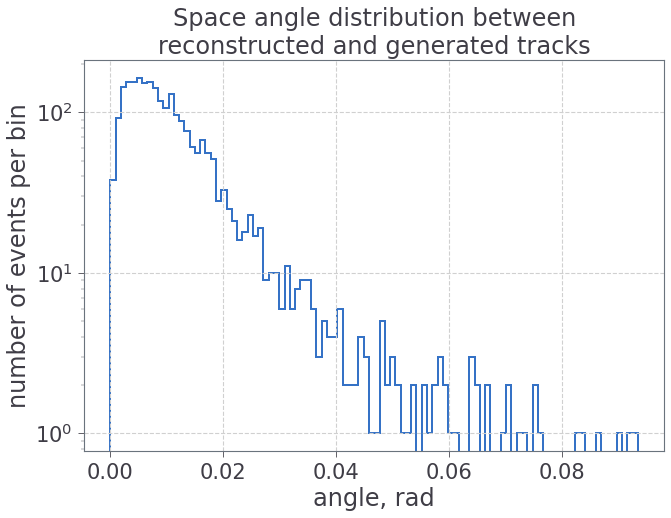

In [13]:
plt.hist( mc_plus['diff'], bins=100, histtype='step', lw=2 );
plt.yscale('log')
my_style('Space angle distribution between\nreconstructed and generated tracks',#'Пространственный угол между реконструированными и\nгенераторными треками после отбора',
         'angle, rad',#'Угол, рад', 
         'number of events per bin',#'Число событий в бине', 
         '--')
# plt.savefig('outputs/images/7_space_angle.png')

In [14]:
mc_minus.head()

,subentry,rec,emeas,gen,diff
entry,,,,,
0,0,"TVector3(158.67, 95.466, -71.957)",775.0,"TVector3(156.72, 94.169, -75.797)",0.022367
2,0,"TVector3(174.72, -161.16, 20.644)",775.0,"TVector3(184.21, -167.5, 26.464)",0.020524
6,0,"TVector3(319.91, -19.83, 94.096)",775.0,"TVector3(310.28, -20.043, 94.348)",0.009402
9,0,"TVector3(-479, -162.58, -143.54)",775.0,"TVector3(-477.18, -160.91, -139.42)",0.006686
18,0,"TVector3(251.45, 346.09, 56.46)",775.0,"TVector3(267.1, 373.46, 58.84)",0.008300


In [15]:
merged_table_rec = build_decay(mc_plus, mc_minus, 'rec')
merged_table_gen = build_decay(mc_plus, mc_minus, 'gen')

In [16]:
merged_table_rec.head()

,plus,minus,angle
entry,,,
0,"TVector3(292.93, 18.944, 340.92)","TVector3(158.67, 95.466, -71.957)",1.301759
2,"TVector3(-179.64, -380.15, 129.1)","TVector3(174.72, -161.16, 20.644)",1.255512
6,"TVector3(212.72, 255.74, -188.86)","TVector3(319.91, -19.83, 94.096)",1.209159
9,"TVector3(-52.457, -97.673, 137.2)","TVector3(-479, -162.58, -143.54)",1.338938
18,"TVector3(235.01, -53.053, -100.12)","TVector3(251.45, 346.09, 56.46)",1.253922


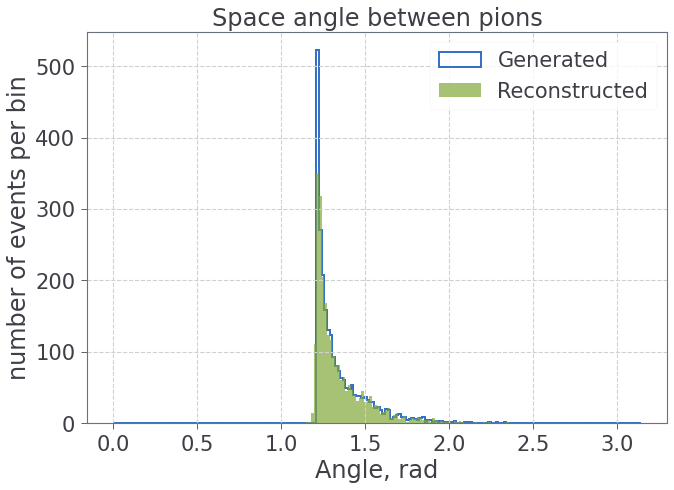

In [17]:
plt.hist( merged_table_gen['angle'], bins=200, histtype='step', lw=2, range=(0,np.pi), label='Generated' );
plt.hist( merged_table_rec['angle'], bins=200, histtype='stepfilled', lw=2, range=(0,np.pi), 
         alpha=0.7, label='Reconstructed' );
plt.legend(frameon=True)
my_style('Space angle between pions',#'Пространственный угол между двумя пионами',
         'Angle, rad',#'Угол, рад', 
         'number of events per bin',#'Число событий в бине', 
         '--')
# plt.savefig('outputs/images/7_space_angle_pions.png')

In [18]:
vec4_table_rec = get_mass_table(merged_table_rec)
vec4_table_gen = get_mass_table(merged_table_gen)

In [19]:
vec4_table_rec.head()

,plus,minus,angle,M
entry,,,,
0,"TVector3(292.93, 18.944, 340.92)","TVector3(158.67, 95.466, -71.957)",1.301759,469.264675
2,"TVector3(-179.64, -380.15, 129.1)","TVector3(174.72, -161.16, 20.644)",1.255512,478.555122
6,"TVector3(212.72, 255.74, -188.86)","TVector3(319.91, -19.83, 94.096)",1.209159,493.363443
9,"TVector3(-52.457, -97.673, 137.2)","TVector3(-479, -162.58, -143.54)",1.338938,491.030874
18,"TVector3(235.01, -53.053, -100.12)","TVector3(251.45, 346.09, 56.46)",1.253922,487.045041


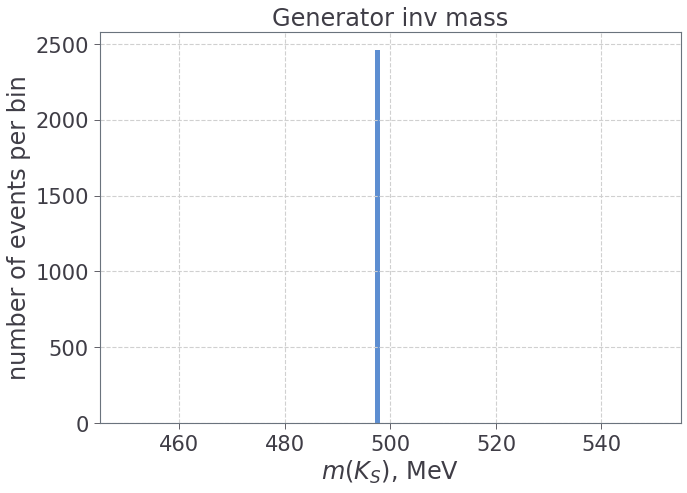

In [20]:
m = vec4_table_gen
plt.hist(m.M, bins=100, range=(450, 550), histtype='stepfilled', alpha=0.8, lw=2);
my_style('Generator inv mass', '$m(K_S)$, MeV', 'number of events per bin', '--');
# plt.savefig('outputs/images/7_gen_K.png')

In [21]:
print('Mean generator inv mass:', m.M.mean(), 'MeV')

Mean generator inv mass: 497.65288465645943 MeV


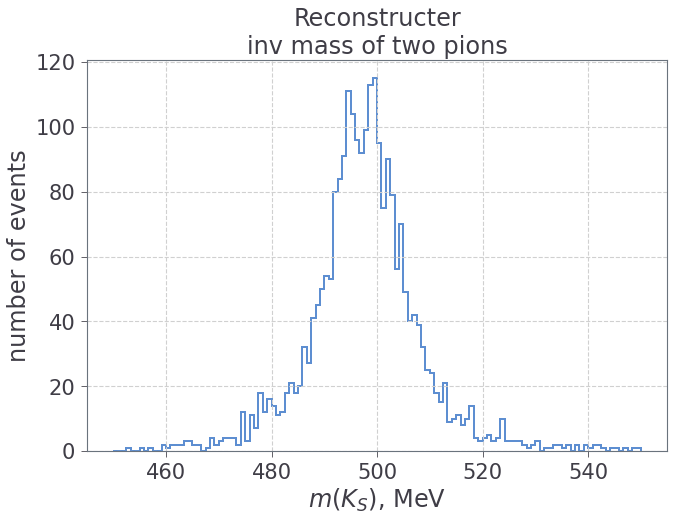

In [22]:
m = vec4_table_rec
plt.hist(m.M, bins=120, range=(450, 550), histtype='step', alpha=0.8, lw=2, density=False);
my_style('Reconstructer\ninv mass of two pions', '$m(K_S)$, MeV', 'number of events', '--')
# plt.savefig('outputs/images/7_rec_K.png')

Постарался и выделил массу KS из привязанных к генератору пионов.

Теперь отфитирую эту штуку двумя гауссами

In [23]:
import iminuit
import probfit as pf

In [62]:
#гаусс + гаусс
def gauss2(x, mu, mu2, sigma1, sigma2, f):
    return f*pf.gaussian(x, mu, sigma1) + (1-f)*pf.gaussian(x, mu + mu2, sigma2)
def const(x):
    return 1

mass_bound=(450,550)
norm_sig = pf.rename( pf.Normalized( gauss2, mass_bound ), ['x', 'M1','dM', 'S1', 'S2', 'f'] )
norm_bkg = pf.rename( pf.Normalized( const, mass_bound ), ['x'] )

ext_sig = pf.Extended(norm_sig, extname='N1')
ext_bkg = pf.Extended(norm_bkg, extname='N2')

pdf = pf.AddPdf(ext_sig, ext_bkg)

limits = {
    "limit_M1": [490, 510],
    "limit_S1": [2, 20],
    "limit_N1": [1000, 100000],
    "limit_dM": [-5, 5],
    "limit_S2": [10, 23],
    "limit_N2": [0, 1000],
    "limit_f": [0, 1],
}
pf.describe(pdf)

['x', 'M1', 'dM', 'S1', 'S2', 'f', 'N1', 'N2']

In [28]:
def fitter(dic, nbins, draw=True):
    
    likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound)
    
    initial_par_values = {"M1": 497.6, "S1": 4.26, "N1": 7000, "S2": 13,"dM": 0.1, 'f': 0.5, 'N2': 1}  
    mt = iminuit.Minuit(likelihood, **initial_par_values, **limits, pedantic=False)
    mt.migrad();
    
    if draw:
        likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound)
    return mt, likelihood

In [38]:
parnames = mt.parameters.copy()
parnames2 = [ f'{i}_err' for i in mt.parameters.copy()]
parnames.extend(parnames2)
res_frame = pd.DataFrame(columns=parnames )

In [30]:
files = glob('/store17/petrov/data/kskl_sim/*.root') #v6
# files = glob('/store17/petrov/data/kskl_sim_custom/tr_ph_v7/*.root') #v7
it = iter(files)

In [31]:
def getM(file):
    mc = uproot.open(file)['tr_ph'] #004880 550 MeV 004916 1000 MeV
    mc_plus, mc_minus = find_pions_from_ks_decay_corrected(mc) #corrected pions
    merged_table_rec = build_decay(mc_plus, mc_minus, 'rec')
    m = get_mass_table(merged_table_rec)
    m['energy'] = mc_minus.emeas.mean()
    print( 'Done', mc_minus.emeas.mean() )
    return m

In [33]:
hists = pd.concat([getM(f) for f in files[:-1]])

Done 562.5
Done 550.0
Done 575.0
Done 587.5
Done 600.0
Done 612.5
Done 625.0
Done 637.5
Done 650.0
Done 662.5
Done 675.0
Done 687.5
Done 700.0
Done 712.5
Done 725.0
Done 737.5
Done 750.0
Done 762.5
Done 775.0
Done 787.5
Done 800.0
Done 812.5
Done 825.0
Done 837.5
Done 850.0
Done 862.5
Done 875.0
Done 887.5
Done 900.0
Done 912.5
Done 925.0
Done 935.0
Done 945.0
Done 950.0
Done 962.5
Done 975.0
Done 987.5
Done 1000.0


In [40]:
h = hists.groupby('energy')
it = iter(h)
def set_arguments(e):
    lim_f, lim_s1, lim_s2, lim_dm = -190/(270 - e) + 0.10, 4.92, 13.4, 0.14
    limits['limit_f'] = [lim_f, lim_f]
    limits['limit_S1'] = [lim_s1, lim_s1]
    limits['limit_S2'] = [lim_s2, lim_s2]
    limits['limit_dM'] = [lim_dm, lim_dm]

In [77]:
f = next(it)
e, m = f
print('Energy', e)

Energy 800.0


In [149]:
def chi2ndf():
    bins=150
    y0, x0 = np.histogram(m.M.values, bins=bins, range=(450, 550));
    x0 = (x0[:-1] + x0[1:])/2
    y0, x0 = y0[y0>0], x0[y0>0]
    y1 = pf.vector_apply(pdf, x0, *mt.values.values())*100/bins
    chi2 = np.sum( ((y1 - y0)**2)/y0 )
    ndf = len(x0) - len(mt.values.values())
    return chi2, ndf

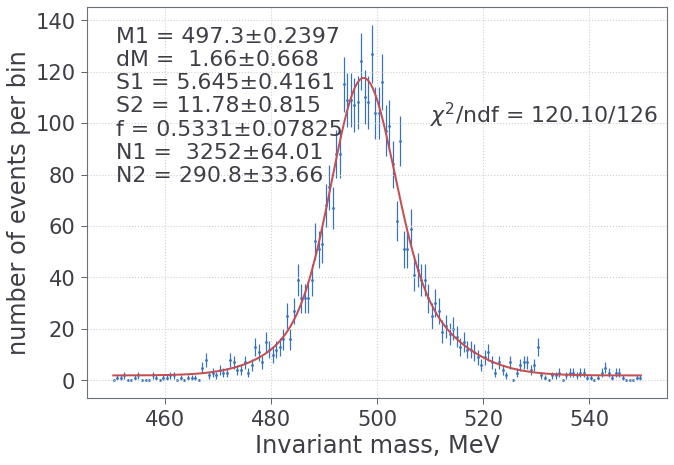

In [152]:
nbins = 150
# set_arguments(e)
mt, lk = fitter(m.M.values, nbins)
vals = mt.values.values()
vals[-2] *= 1-vals[-3]
vals[-3] = 0
# pf.draw_pdf(pdf, arg=vals, bound=mass_bound, bins=nbins, density=False);
# my_style(f'Fit $E_b = $ {e:.2f} MeV', 'Invariant mass, MeV', 'number of events per bin')
my_style('', 'Invariant mass, MeV', 'number of events per bin')
plt.text(510, 100, f'$\\chi^2$/ndf = {chi2ndf()[0]:.2f}/{chi2ndf()[1]}')
res_frame.loc[e] = mt.values.values() + mt.errors.values();
# plt.savefig('outputs/images/7_fit_K800.pdf')

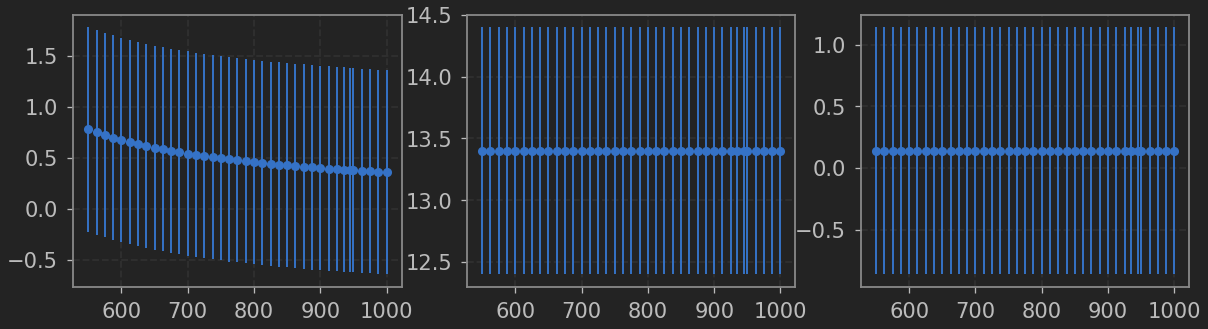

In [231]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.errorbar(x=res_frame.index, y=res_frame.f, yerr=res_frame.f_err, fmt='o');
plt.subplot(132)
plt.errorbar(x=res_frame.index, y=res_frame.S2, yerr=res_frame.S2_err, fmt='o');
plt.subplot(133)
plt.errorbar(x=res_frame.index, y=res_frame.dM, yerr=res_frame.dM_err, fmt='o');

In [155]:
res_frame.tail()

,M1,dM,S1,S2,f,N1,N2,M1_err,dM_err,S1_err,S2_err,f_err,N1_err,N2_err
950.0,497.179790,0.62,4.8,13.999999,0.412463,1478.033803,32.858426,0.241049,1.0,1.0,1.282394,0.025659,39.131028,9.270673
962.5,497.126354,0.62,4.8,12.767558,0.315188,1276.212834,27.677128,0.284432,1.0,1.0,0.552133,0.041359,36.543596,9.308563
975.0,497.607971,0.62,4.8,14.000000,0.346383,1083.930992,14.150013,0.306866,1.0,1.0,0.350125,0.030390,33.396743,6.775988
987.5,497.541859,0.62,4.8,14.000000,0.366233,1000.000005,7.827488,0.326865,1.0,1.0,0.294066,0.033110,10.452872,6.608070
1000.0,497.498694,0.62,4.8,13.999995,0.344046,1000.000070,19.306139,0.341227,1.0,1.0,0.115236,0.033862,4.225982,7.279427


In [230]:
for e, m in h:
    print(f'Energy {e}')
    set_arguments(e)
    mt, lk = fitter(m.M.values, nbins, draw=False)
    res_frame.loc[e] = mt.values.values() + mt.errors.values();

Energy 550.0
Energy 562.5
Energy 575.0
Energy 587.5
Energy 600.0
Energy 612.5
Energy 625.0
Energy 637.5
Energy 650.0
Energy 662.5
Energy 675.0
Energy 687.5
Energy 700.0
Energy 712.5
Energy 725.0
Energy 737.5
Energy 750.0
Energy 762.5
Energy 775.0
Energy 787.5
Energy 800.0
Energy 812.5
Energy 825.0
Energy 837.5
Energy 850.0
Energy 862.5
Energy 875.0
Energy 887.5
Energy 900.0
Energy 912.5
Energy 925.0
Energy 935.0
Energy 945.0
Energy 950.0
Energy 962.5
Energy 975.0
Energy 987.5
Energy 1000.0


In [228]:
def chisq(k):
#     foo = k/(b - res_frame.index) + c
    foo= k
    return np.square((res_frame.S2 - foo)/res_frame.S2_err).sum()
mt2 = iminuit.Minuit(chisq, k=1)#, b=1, c=0.1)
mt2.migrad()

------------------------------------------------------------------
| FCN = 100.7                   |      Ncalls=15 (15 total)      |
| EDM = 6.23E-15 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | k    |   13.41   |   0.07    |            |            |         |         |       |
------------------------------------------------------------------------------------------

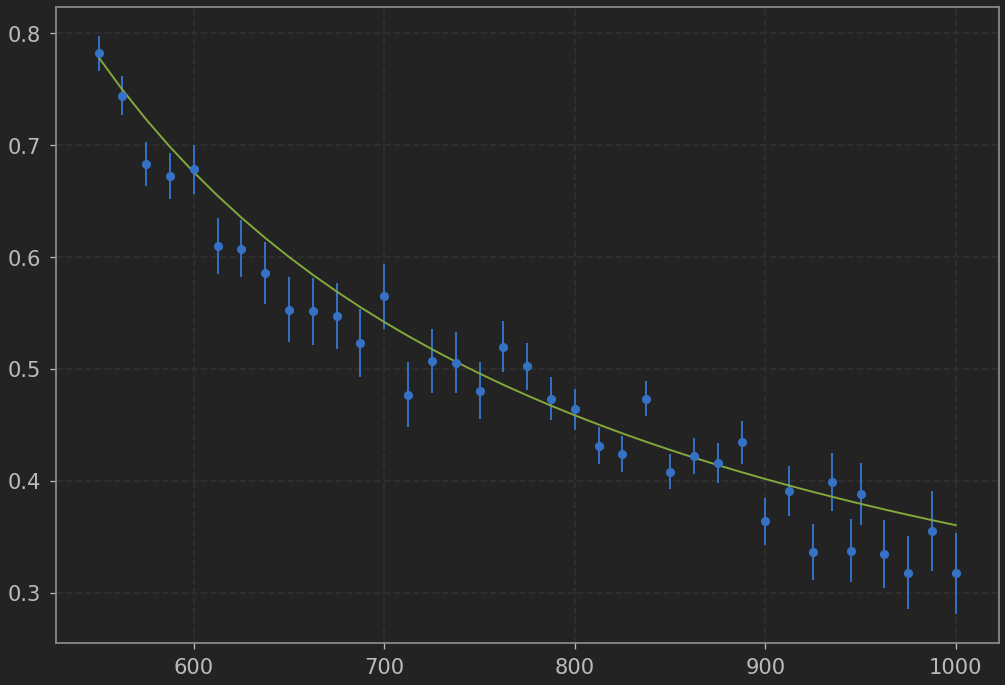

In [216]:
plt.errorbar(x=res_frame.index, y=res_frame.f, yerr=res_frame.f_err, fmt='o');
xx = res_frame.index
yy = -190/(270 - xx) + 0.10
plt.plot(xx, yy)

In [197]:
e = [812.5, 550, 687.5, 935, 625, 950, 775]
s1 = [5.249, 4.034, 4.157, 6.075, 4.164, 5.163, 4.998]
ds1 = [0.025, 0.080, 0.11, 0.276, 0.094, 0.31, 0.16]
s2 = [14.94, 14.4, 14.33, 19.34, 14.64, 16.38, 17.18]
ds2 = [0.67, 0.598, 0.50, 1.503, 0.589, 0.795, 0.89]
f = [0.4619, 0.6924, 0.57, 0.476, 0.651, 0.378, 0.5341]
df = [0.032, 0.013, 0.017, 0.03, 0.0148, 0.03, 0.02]

In [55]:
mt.matrix(correlation=True)

--------------------------------------------------
|    |     M1     S1     S2      f     N1     N2 |
--------------------------------------------------
| M1 |  1.000 -0.021 -0.009 -0.036 -0.005  0.013 |
| S1 | -0.021  1.000 -0.170 -0.149  0.050 -0.137 |
| S2 | -0.009 -0.170  1.000  0.571  0.245 -0.675 |
|  f | -0.036 -0.149  0.571  1.000  0.126 -0.346 |
| N1 | -0.005  0.050  0.245  0.126  1.000 -0.281 |
| N2 |  0.013 -0.137 -0.675 -0.346 -0.281  1.000 |
--------------------------------------------------

# 2/27-28/20
___
Метод сайд-бендов не прокатывает, так как в них есть сигнал, поэтому ищу распределение нефизического фона

In [166]:
it = uproot.pandas.iterate('../../outputs/others/underThreshold/*.root', treepath='pic_mom')

In [167]:
unph_bkg = pd.concat([i for i in it], ignore_index=True)

In [168]:
unph_bkg

,align,momentum,mass,passed
0,0.999892,418.163818,3.488998,False
1,0.992468,627.972290,40.252934,False
2,0.999968,471.809113,4.114306,False
3,0.999943,490.961884,15.202196,False
4,0.999997,482.764221,15.375327,False
...,...,...,...,...
1424,0.982825,61.044605,421.889160,False
1425,0.999975,36.624336,543.150757,False
1426,-0.985567,37.716602,498.424438,False
1427,0.815877,20.443487,534.720520,False


In [169]:
unph_bkg = unph_bkg.query('align>0.8')

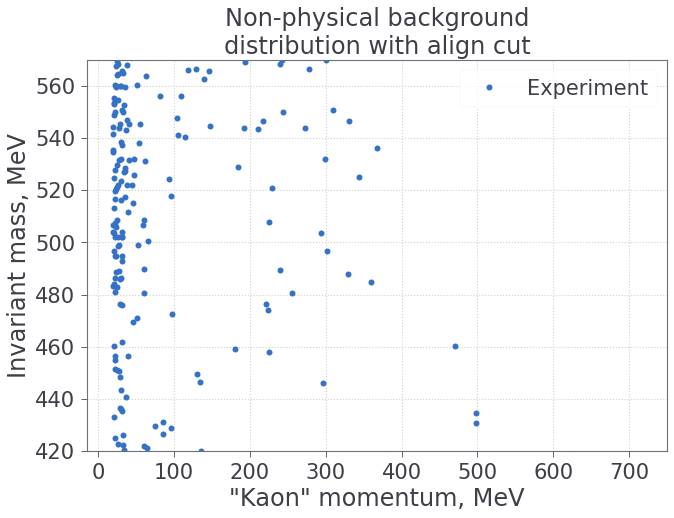

In [170]:
plt.plot(unph_bkg.momentum, unph_bkg.mass, '.', label='Experiment', ms=12)
plt.ylim(420, 570);
# plt.text(500, 530, "$E_{beam}$ = 490 MeV\nRHO2013,18\nL = 100+100 nb")
plt.legend();
my_style('Non-physical background\ndistribution with align cut', '"Kaon" momentum, MeV', 'Invariant mass, MeV')
# plt.savefig('outputs/images/7_nonphys_bkg.png')

In [190]:
xi=0.7
m0 = 497.6
p0 = np.sqrt(537**2 - m0**2)
un2 = unph_bkg[ abs( (unph_bkg.momentum - p0)*np.cos(xi) - (unph_bkg.mass - m0)*np.sin(xi) ) < 10 ].query('abs(mass-500)<50')

In [191]:
un2

,align,momentum,mass,passed
1230,0.974611,229.575317,520.785339,False
1384,0.995514,180.163879,459.109741,False


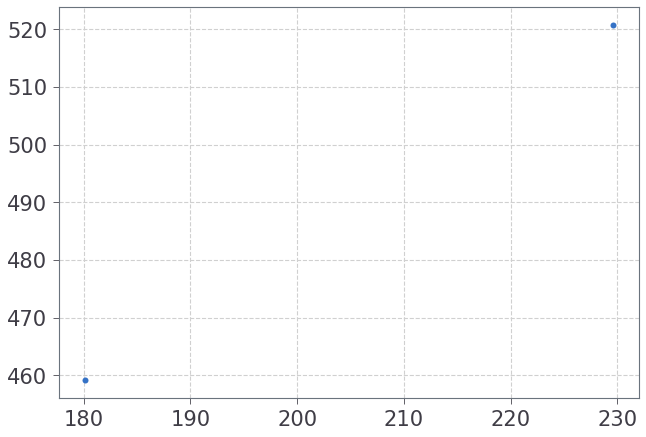

In [192]:
plt.plot(un2.momentum, un2.mass, '.', label='Experiment', ms=12)

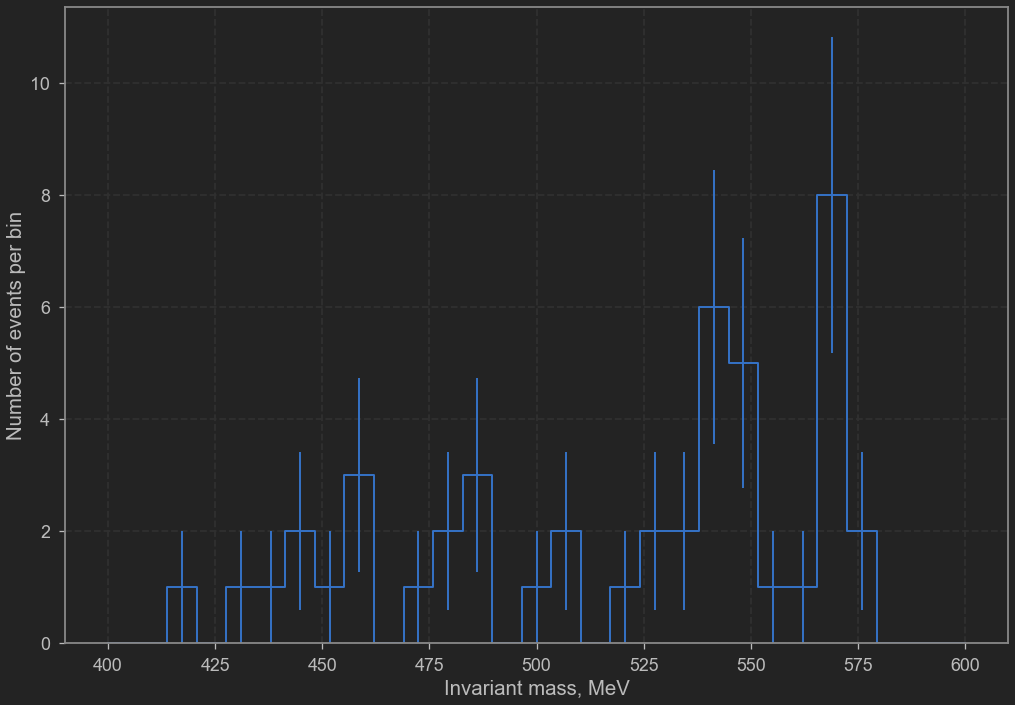

In [108]:
hist, bins = np.histogram(unph_bkg.query('momentum>100').mass, bins=np.linspace(400, 600, 30));
hep.histplot(hist, bins, yerr=True);
plt.ylabel('Number of events per bin');
plt.grid(linestyle='--')
plt.xlabel('Invariant mass, MeV');
# plt.savefig('outputs/images/7_nonphys_bkg_minv.png')

In [109]:
import probfit as pf
from iminuit import Minuit

In [110]:
def line(x, c):
    return c

chi2 = pf.BinnedChi2(line, unph_bkg.mass, bound=(430, 520), bins=20)

In [111]:
m = Minuit(chi2)
m.migrad()

------------------------------------------------------------------
| FCN = 21.11                   |      Ncalls=13 (13 total)      |
| EDM = 5.6E-19 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | c    |   0.65    |   0.09    |            |            |         |         |       |
------------------------------------------------------------------------------------------

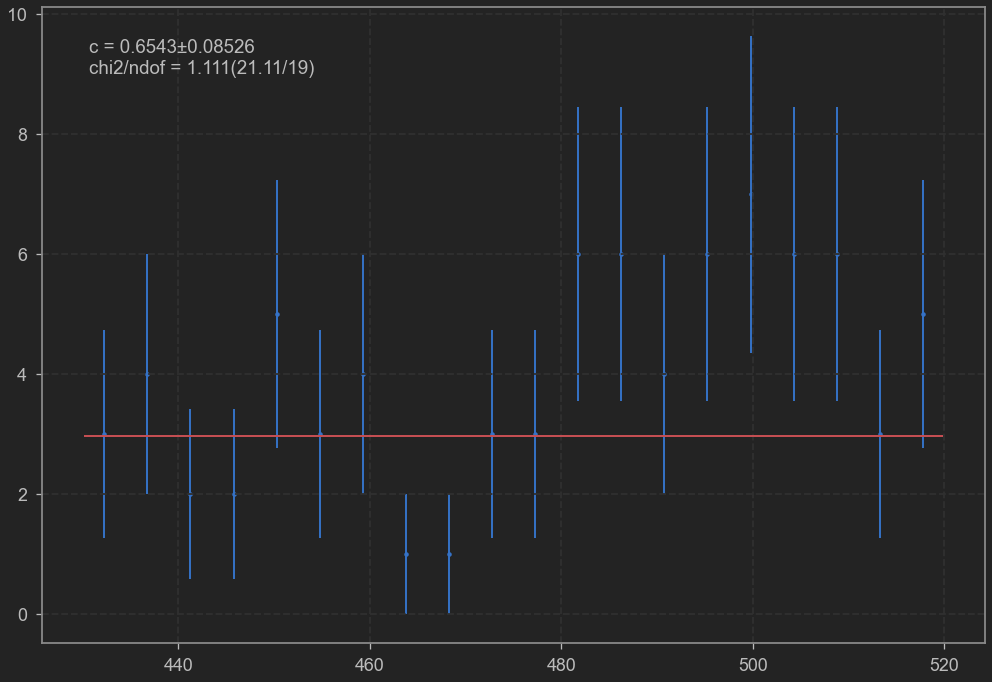

In [112]:
chi2.draw(m);

## Физический фон
____
Раз уж я этим занялся, то посмотрю на распределение физического фона для моих событий

Для этого я намоделировал 100 000 событий на мультиадронном генераторе на энергии 1.9 ГэВ, а потом нашёл кучу уже сгенерированных файлов на [Cmd3Off](https://cmd.inp.nsk.su/~cmd3off/) по 300 000 событий

In [156]:
%ls ../../outputs/others/multihadrons/trees

1002.31_45668.root  674.85_45658.root  749.55_45655.root  924.32_45669.root
1003.31_45641.root  700.56_45657.root  774.85_45654.root  937.12_45648.root
575.31_45672.root   711.53_45667.root  800.86_45653.root  937.12_45650.root
598.04_45875.root   717.46_45665.root  825.05_45652.root  938.18_45647.root
641.02_45660.root   721.70_45670.root  839.47_45651.root  938.75_45643.root
649.77_45659.root   724.94_45656.root  867.15_45664.root  940.56_45649.root


In [158]:
ebeams = [575.31, 598.04, 641.02, 649.77, 674.85, 749.55, 825.05, 950.00, 1003.31]
ebeam = ebeams[3]
mh_tree = uproot.open(glob(f"../../outputs/others/multihadrons/trees/{ebeam}*.root")[0])['pic_mom']

In [159]:
mh = mh_tree.pandas.df(flatten=False).query('align>0.8')

In [160]:
def simtypes_to_process(st):
    st = st.copy()
    parts_dict = {111:'$\pi^0$', 211:'$\pi^+$', -211: '$\pi^-$', 321: '$K^+$', -321: '$K^-$', 310:'$K_S$', 130:'$K_L$', \
                  2212:'$p^+$', -2212:'$p^-$', 221:'$\eta$'}
    num_particles = list(map(lambda x: ''.join(list(map(lambda y: parts_dict[y], x))) , st)) 
    return num_particles

In [161]:
mh['process_type'] = simtypes_to_process(mh['simtypes'])
mh['is_kskl'] = (mh['process_type'] == '$K_L$$K_S$')

In [162]:
mh.head()

,align,momentum,mass,passed,m1,m2,simtypes,gamma_energy,process_type,is_kskl
entry,,,,,,,,,,
0,0.953029,279.013763,559.521240,False,120.992947,-91.999205,"[130.0, 310.0]",235.451569,$K_L$$K_S$,True
1,0.999990,191.802963,486.876129,False,99.186205,-203.388171,"[130.0, 310.0]",245.803024,$K_L$$K_S$,True
2,0.993995,180.042480,509.842926,False,124.978890,-202.667005,"[130.0, 310.0]",248.921204,$K_L$$K_S$,True
4,0.999866,147.169525,493.567139,False,126.499858,-239.316959,"[130.0, 310.0]",254.743820,$K_L$$K_S$,True
5,0.917501,82.938293,502.851074,False,165.503925,-291.187233,"[130.0, 310.0]",250.917191,$K_L$$K_S$,True


Составлю некоторый рейтинг процессов, которые пытаются пролезть

In [163]:
mh.groupby('process_type').agg({'momentum':'count'}).sort_values(by='momentum', ascending=False)

,momentum
process_type,
$K_L$$K_S$,1772
$\pi^+$$\pi^0$$\pi^0$$\pi^-$,36
$\pi^+$$\pi^+$$\pi^-$$\pi^-$,17
$\pi^-$$K_S$$K^+$,11
$\pi^+$$\pi^-$$\pi^0$,10
$\pi^+$$K_S$$K^-$,8
$K^+$$K^-$,7
$K_S$$K_L$$\pi^+$$\pi^-$,6
$K_S$$K_S$$\pi^+$$\pi^-$,6


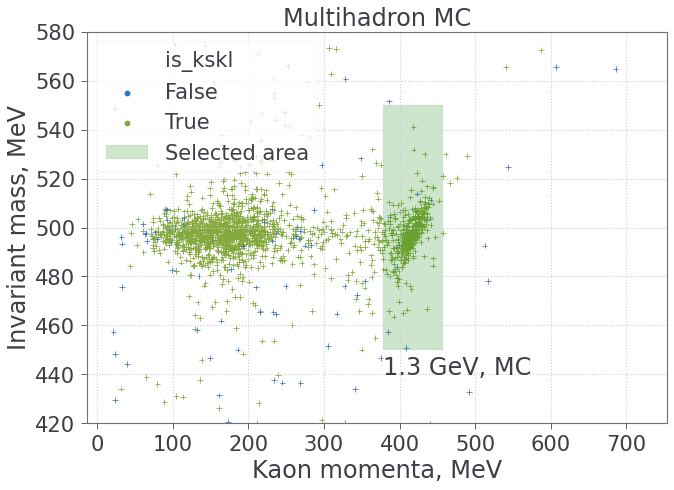

In [164]:
p_cut = 2 * (0.0869 * ebeam - 36.53)
p0 = np.sqrt(ebeam**2 - 497.6**2)

sns.scatterplot(data=mh, x='momentum', y='mass', hue='is_kskl', marker="+", legend='brief')
plt.fill_between([p0-p_cut, p0+p_cut], [450, 450], [550, 550], color='green', alpha=0.2, label='Selected area')
plt.grid(linestyle=":")
# plt.xlim(50, 350);
plt.ylim(420, 580);
plt.text(p0-p_cut, 440, f"{ebeam*2e-3:.1f} GeV, MC", size=24);
plt.title('Multihadron MC')
plt.xlabel('Kaon momenta, MeV');
plt.ylabel('Invariant mass, MeV');
plt.legend(frameon=True, loc='upper left');
# plt.savefig('outputs/images/7_invMass_mom_dist_19_1.5GeV.png')

Нужно отметить, что событий распределённых равномерно по массе и близко к нулю по импульсу в физическом моделировании нет

Ну и финальная картинка: распределение по инвариантной массе

In [59]:
print('Found events:', len(mh.query('abs(mass-500)<50&passed')))
print('Found events KSKL:', len(mh.query('is_kskl==True&abs(mass-500)<50&passed')))
print('Found events non-KSKL:', len(mh.query('is_kskl==False&abs(mass-500)<50&passed')))

Found events: 219
Found events KSKL: 215
Found events non-KSKL: 4


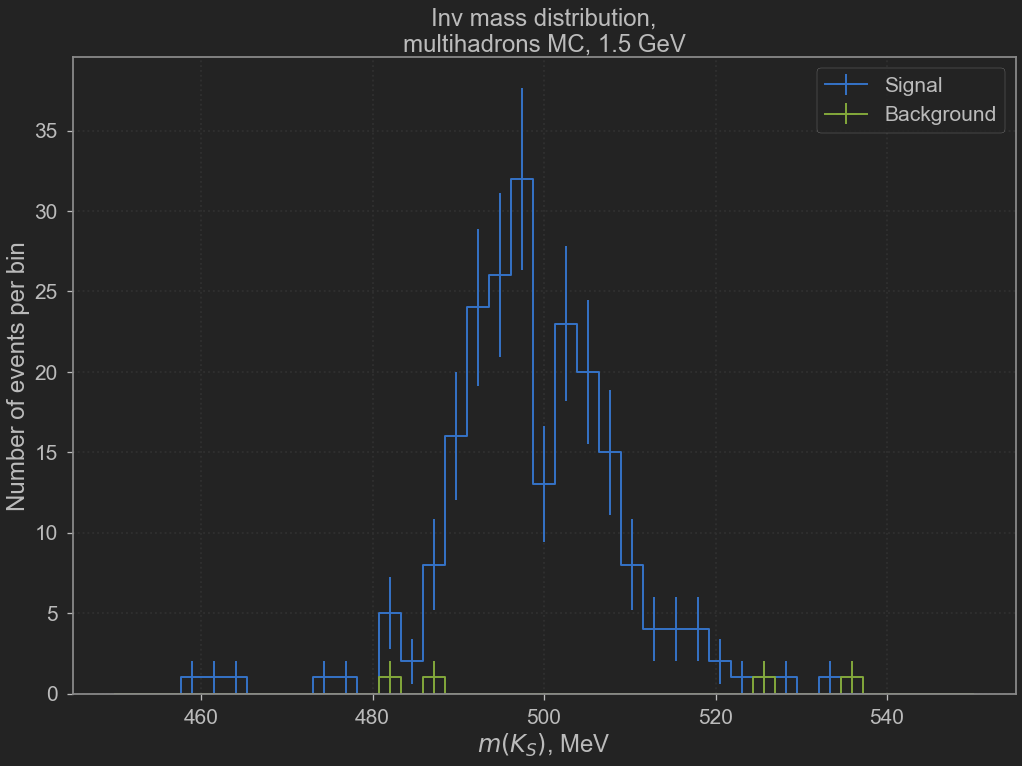

In [62]:
bins = np.linspace(450, 550, 40)
h1, _ = np.histogram(mh.query('is_kskl==True&passed').mass, bins=bins)
h2, _ = np.histogram(mh.query('is_kskl==False&passed').mass, bins=bins)

hep.histplot([h1, h2], bins=bins, stack=False, yerr=True, label=['Signal',"Background"])
my_style(f'Inv mass distribution,\nmultihadrons MC, {ebeam*0.002:.1f} GeV', \
         '$m(K_S)$, MeV', "Number of events per bin", ':')
plt.legend(frameon=True)
# plt.savefig('outputs/images/7_invMass_inv_dist_19_1.5GeV.png')

Посмотрю, есть ли в моём фоне космика

In [125]:
cosmic_tree = uproot.open("../../outputs/others/cosmic.root")['pic_mom']

In [126]:
cosmic_df = cosmic_tree.pandas.df(flatten=False)

In [127]:
len(cosmic_df)

0

Видно, что космика даже не пытается показаться

In [128]:
ee_tree = uproot.open("../../outputs/others/ee_1.9.root")['pic_mom']
ee_df = cosmic_tree.pandas.df(flatten=False)

In [129]:
len(ee_df)

0

$e^+e^-$ у меня тоже нету

$K^+K^-$ тоже проверил, нету